In [1]:
import json

with open('robot_data.json') as json_file:
    robot_data = json.load(json_file)
robot_data

{'start': [0, 0],
 'finish': [10, 10],
 'obstacles': [[[2, 2], [2, 4], [3, 3]], [[5, 4], [4, 6], [6, 5], [7, 4]]]}

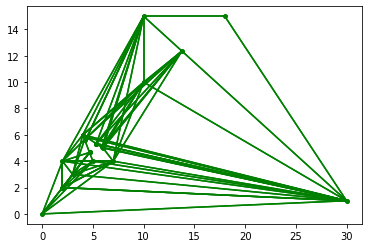

In [6]:
import importlib
import sys
# importlib.reload(sys.modules['graph'])
# importlib.reload(sys.modules['interception'])
import numpy as np
from interception import calc_interception, check_is_point_on_line, NoInterceptionException
from graph import Graph, VertexNotFoundException
from pprint import pprint
%matplotlib inline
from matplotlib import pyplot as plt


robot_data['obstacles'] = [
    [[2, 2], [2, 4], [3, 3]],
    [[5, 4], [4, 6], [6, 5], [7, 4]],
    [[10, 15], [18, 15], [30, 1]]]

def find_interceptions(line, obstacles):
    interceptions = []
    for obstacle in robot_data['obstacles']:
        for pindex in range(len(obstacle)):
            obstacle_line = np.array([obstacle[pindex - 1], obstacle[pindex]])
            try:
                new_point, is_edge = calc_interception(line, obstacle_line)
                if not is_edge:
                    interceptions.append([tuple(new_point), obstacle_line])
            except NoInterceptionException:
                continue
    return interceptions


def find_obstacle_index(location, obstacles):
    for obstacle_index, obstacle in enumerate(robot_data['obstacles']):
        for pindex in range(len(obstacle)):
            obstacle_line = np.array([obstacle[pindex - 1], obstacle[pindex]])
            if check_is_point_on_line(location, obstacle_line):
                return obstacle_index
    return None

finish_location = tuple(robot_data['finish'])
start_location = tuple(robot_data['start'])
iter_locations = [tuple(robot_data['start']), *[tuple(item) for sublist in robot_data['obstacles'] for item in sublist]]
locations = set(iter_locations)
locations.add(finish_location)

while True:
    new_locations = []
    for v in iter_locations:
        line = np.array([v, finish_location])
        interceptions = find_interceptions(line, robot_data['obstacles'])
        new_locations = new_locations + list(map(lambda r: r[0], interceptions))
    locations_len = len(locations)
    locations.update(new_locations)
    if locations_len >= len(locations):
        break
    iter_locations = new_locations
    
g = Graph()
for location in locations:
    g.add_vertex(location)
    
for obstacle in robot_data['obstacles']:
    for pindex in range(len(obstacle)):
        g.add_edge(tuple(obstacle[pindex - 1]), tuple(obstacle[pindex]))

for location_from_index, location_from in enumerate(locations):
    for location_to_index, location_to in enumerate(locations):
        if location_to_index > location_from_index and not np.allclose(location_from, location_to):
            line = np.array([location_from, location_to])
            interceptions = find_interceptions(line, robot_data['obstacles'])
            obstacle_from_index = find_obstacle_index(location_from, robot_data['obstacles'])
            obstacle_to_index = find_obstacle_index(location_to, robot_data['obstacles'])
            if not interceptions and (obstacle_from_index is None or obstacle_from_index != obstacle_to_index):
                g.add_edge(location_from, location_to)

for v in g.vertices():
    plt.plot(v[0], v[1], color='green', marker='o', markersize=4)
    for v_n in g.neighbors(v):
        plt.plot(*zip(v, v_n), color='green')
plt.show()